In [924]:
import torch
import matplotlib.pyplot as plt

In [925]:
def quantize_tensor_uniform(x, num_bits=4):
    n_levels = 2**num_bits

    scale = (x.max() - x.min()) / (n_levels -1)
    zero = -x.min() / scale - n_levels / 2

    x_quantized = torch.clamp(torch.round(x / scale) + zero, -n_levels, n_levels-1)

    x_dequantized = (x_quantized - zero) * scale

    return x_quantized, x_dequantized


def quantize_tensor_PoQ(x, num_bits=4):
    n_levels = 2**num_bits

    s = (x.max()) / 2 ** (n_levels - 1)

    x = x / s

    x = torch.log2(x)
    x = torch.round(x).int()
    x_quantized = torch.clamp(x, 0, n_levels - 1).int()
    print(x_quantized.max(), x_quantized.min(), s)
    x_dequantized = 2 ** (x_quantized) * s
    return x_quantized, x_dequantized


def round_ste(x: torch.Tensor):
    """
    Implement Straight-Through Estimator for rounding operation.
    """
    return (x.round() - x).detach() + x


def lp_loss(pred, tgt, p=2.0, reduction="none"):
    """
    loss function measured in L_p Norm
    """
    if reduction == "none":
        return (pred - tgt).abs().pow(p).sum(1).mean()
    else:
        return (pred - tgt).abs().pow(p).mean()


class LogSqrt2Quantizer():
    """
    PyTorch Function that can be used for asymmetric quantization (also called uniform affine
    quantization). Quantizes its argument in the forward pass, passes the gradient 'straight
    through' on the backward pass, ignoring the quantization that occurred.
    Based on https://arxiv.org/abs/1806.08342.
    :param n_bits: number of bit for quantization
    :param channel_wise: if True, compute scale and zero_point in each channel
    """

    def __init__(
        self, n_bits: int = 4, channel_wise: bool = False, is_act: bool = False
    ):
        super(LogSqrt2Quantizer, self).__init__()
        assert 2 <= n_bits <= 8, "bitwidth not supported"
        self.n_bits = n_bits
        self.n_levels = 2**self.n_bits
        self.delta = None
        self.inited = 0
        self.maxv = None
        self.minv = None

    def forward(self, x: torch.Tensor):
        if self.inited == 0:
            self.delta = self.init_quantization_scale(x)
            # self.delta = Parameter(delta).contiguous()

            self.inited = 1

        x = x + self.delta
        x = self.logk(x, self.base)
        delta = (self.maxv - self.minv) / (self.n_levels)
        x_int = round_ste((x - self.minv) / delta)
        x_int = torch.clamp(x_int, 0, self.n_levels)
        x_float_q = self.base ** round_ste((x_int * delta + self.minv))
        x_dequant = x_float_q - self.delta

        return x_int, x_dequant

    def init_quantization_scale(self, x: torch.Tensor):
        x_clone = x.clone().detach()
        cur_bias = -10
        self.base = 2
        best_score = 1e10
        for bias in [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1.0]:
            x_q, maxv, minv = self.quantize(x_clone, bias)
            score = lp_loss(x_clone, x_q, p=2, reduction="all")
            if score < best_score:
                best_score = score
                cur_bias = bias
                self.maxv = maxv
                self.minv = minv
        return torch.tensor(cur_bias)

    def logk(self, x, k):
        natural_log = torch.log(x)
        log_k = natural_log / torch.log(torch.tensor(k, dtype=x.dtype))
        return log_k

    def quantize(self, x, bias):

        x = x + bias
        x = self.logk(x, self.base)
        maxv = torch.max(x)
        minv = torch.min(x)

        delta = (maxv - minv) / (self.n_levels - 1)
        x_int = round_ste((x - minv) / delta)
        x_int = torch.clamp(x_int, 0, self.n_levels - 1)
        # x_int = torch.clamp(x_int, 0, self.n_levels)
        x_float_q = self.base ** torch.round((x_int * delta + minv))
        x_float_q = x_float_q - bias

        return x_float_q, maxv, minv


x = torch.linspace(0.000001, 1, 1000)

L2 distance with Uniform: 0.6082727313041687
tensor(15, dtype=torch.int32) tensor(0, dtype=torch.int32) tensor(3.0518e-05)

L2 distance with PoQ: 3.596611499786377
L2 distance with LogSqrt2Quantizer(I&S-ViT): 3.5165059566497803


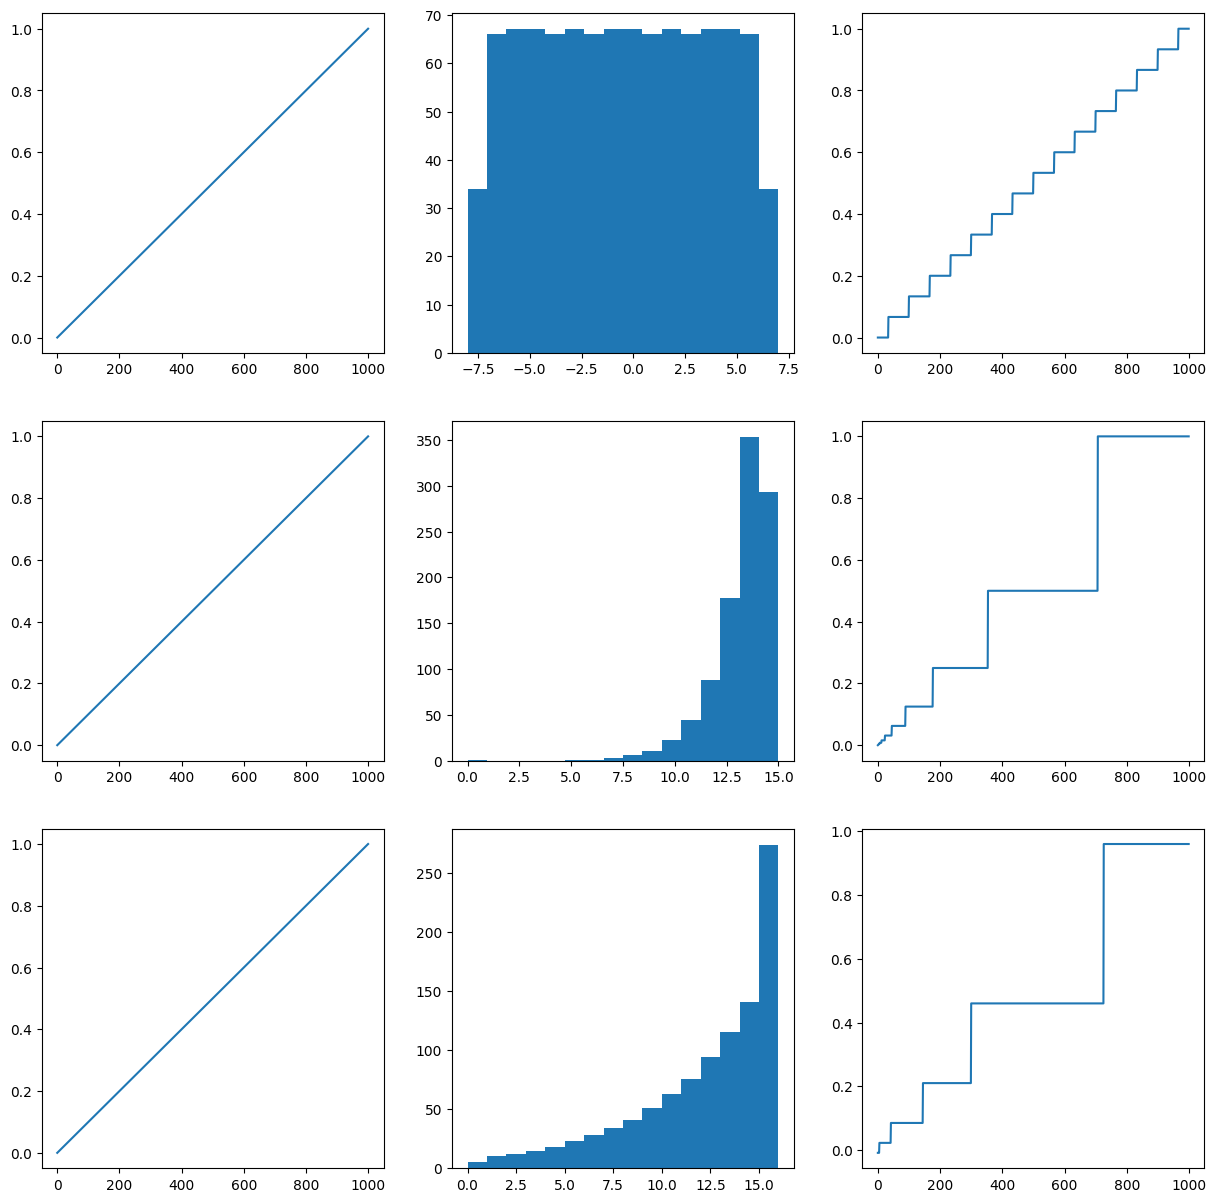

In [926]:
quant, dequant = quantize_tensor_uniform(x, num_bits=4)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes[0][0].plot(x)
axes[0][1].hist(quant, bins=2**4)
axes[0][2].plot(dequant)

print(f"L2 distance with Uniform: {torch.norm(x - dequant, p=2)}")


quant, dequant = quantize_tensor_PoQ(x, num_bits=4)

print(f"")
axes[1][0].plot(x)
axes[1][1].hist(quant, bins=2**4)
axes[1][2].plot(dequant)
print(f"L2 distance with PoQ: {torch.norm(x - dequant, p=2)}")


dja = LogSqrt2Quantizer(n_bits=4)
dja.inited = 0
quant, dequant = dja.forward(x)
axes[2][0].plot(x)
axes[2][1].hist(quant, bins=2**4)
axes[2][2].plot(dequant)
print(f"L2 distance with LogSqrt2Quantizer(I&S-ViT): {torch.norm(x - dequant, p=2)}")

plt.show()

L2 distance with UniformAffineQuantizer: 105.00345611572266
tensor(15, dtype=torch.int32) tensor(3, dtype=torch.int32) tensor(0.0018)
L2 distance with PoQ: 56.39282989501953
L2 distance with LogSqrt2Quantizer: 588.4813842773438


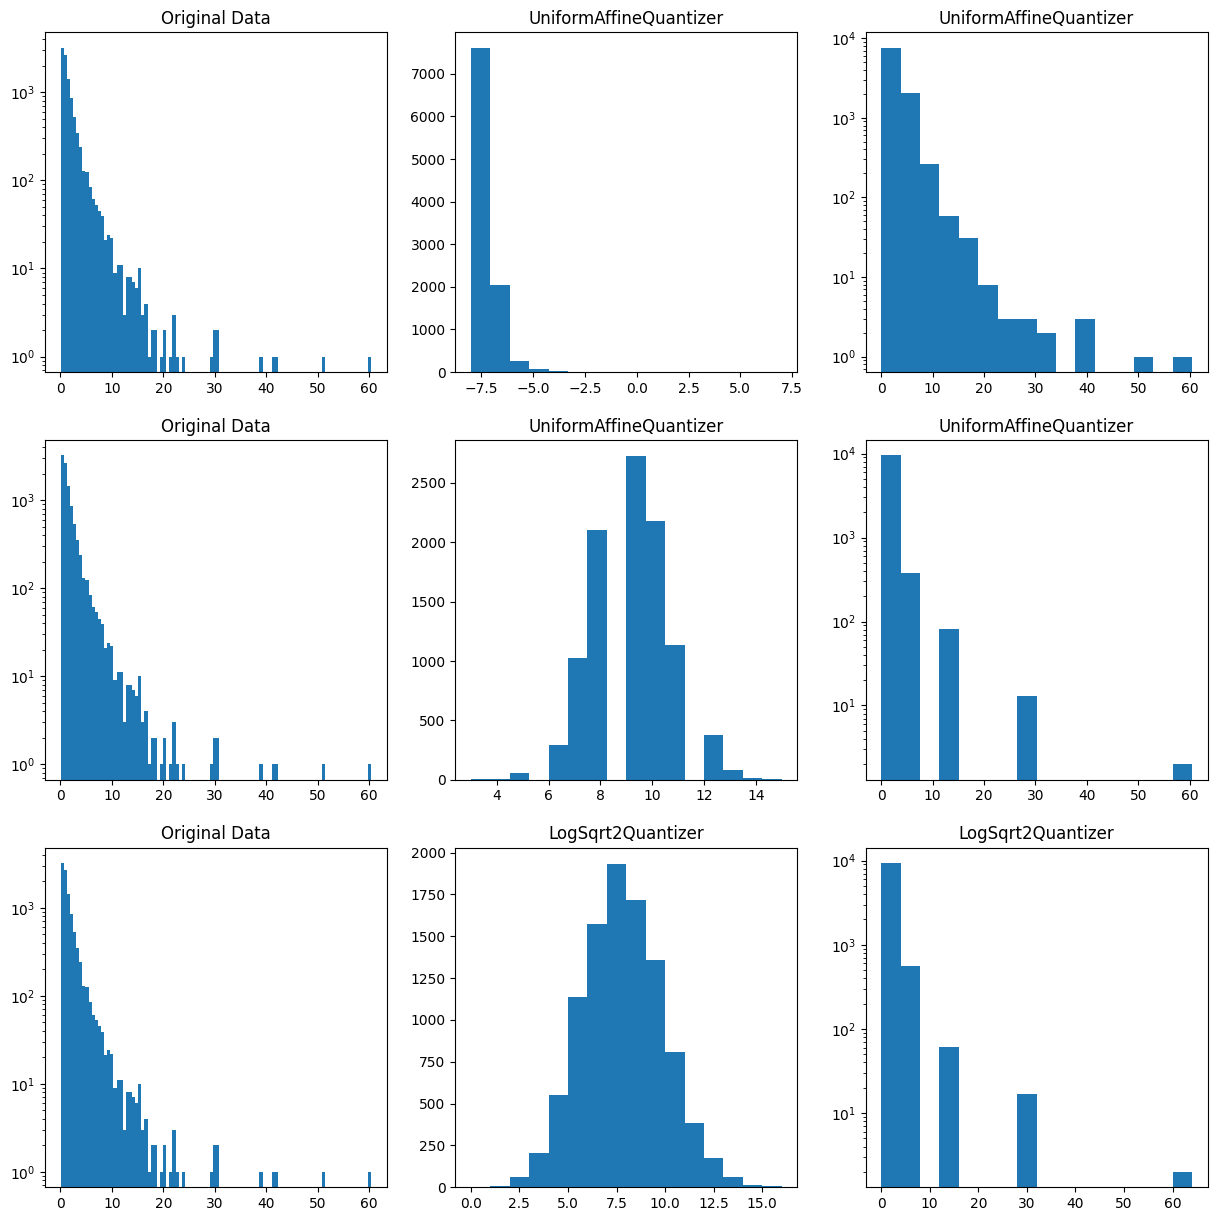

In [927]:
# Example usage
x = torch.randn(10000)
x = torch.exp(x)
x = x[x > 0]  # Remove negative values
quant, dequant = quantize_tensor_uniform(x, num_bits=4)
# logquant, logdequant = log2_quantization(x, num_bits=4)

print(f"L2 distance with UniformAffineQuantizer: {torch.norm(x - dequant, p=2)}")
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes[0][0].hist(x, bins=100)
axes[0][0].set_yscale("log")
axes[0][0].set_title("Original Data")
axes[0][1].hist(quant, bins=16)
axes[0][1].set_title("UniformAffineQuantizer")
axes[0][2].hist(dequant, bins=16)
axes[0][2].set_title("UniformAffineQuantizer")
axes[0][2].set_yscale("log")


quant, dequant = quantize_tensor_PoQ(x, num_bits=4)

axes[1][0].hist(x, bins=100)
axes[1][0].set_yscale("log")
axes[1][0].set_title("Original Data")
axes[1][1].hist(quant, bins=16)
axes[1][1].set_title("UniformAffineQuantizer")
axes[1][2].hist(dequant, bins=16)
axes[1][2].set_title("UniformAffineQuantizer")
axes[1][2].set_yscale("log")
print(f"L2 distance with PoQ: {torch.norm(x - dequant, p=2)}")


dja = LogSqrt2Quantizer()
reflogquant, reflogdequant = dja.forward(x)

axes[2][0].hist(x, bins=100)
axes[2][0].set_yscale("log")
axes[2][0].set_title("Original Data")
axes[2][1].hist(reflogquant, bins=16)
axes[2][1].set_title("LogSqrt2Quantizer")
axes[2][2].hist(reflogdequant, bins=16)
axes[2][2].set_title("LogSqrt2Quantizer")
axes[2][2].set_yscale("log")
print(f"L2 distance with LogSqrt2Quantizer: {torch.norm(x - reflogquant, p=2)}")


plt.show()

L2 distance with UniformAffineQuantizer: 4.651978015899658
tensor(15, dtype=torch.int32) tensor(1, dtype=torch.int32) tensor(0.0001)
L2 distance with PoQ: 14.563497543334961
L2 distance with LogSqrt2Quantizer: 700.1056518554688


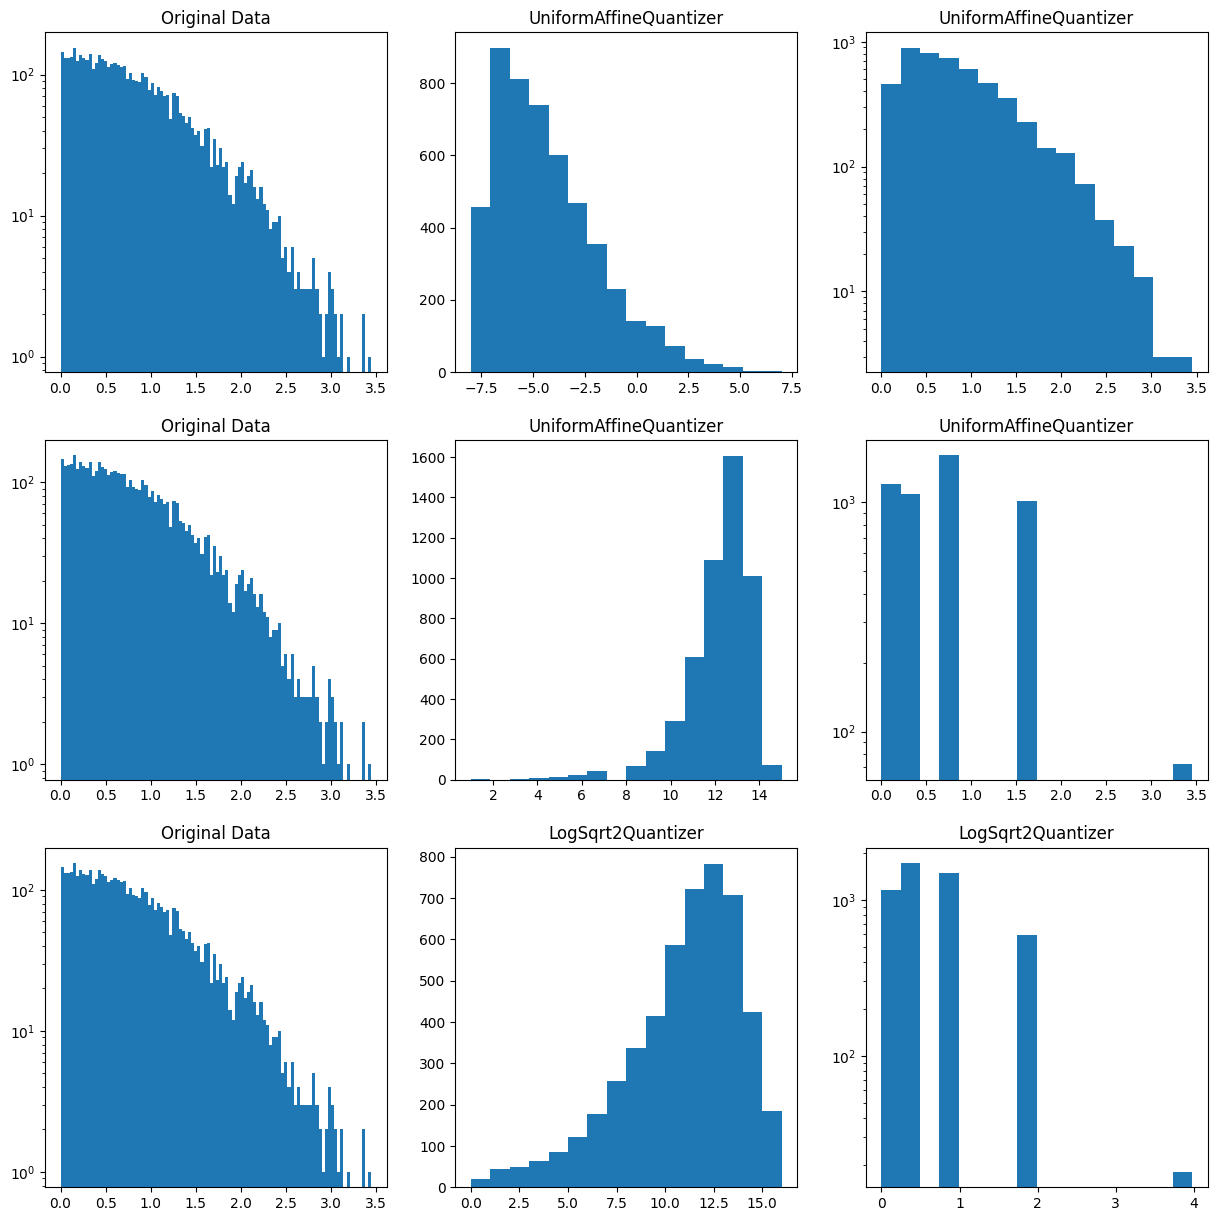

In [928]:
# Example usage
x = torch.randn(10000)
# x = torch.exp(x)
x = x[x > 0]  # Remove negative values
quant, dequant = quantize_tensor_uniform(x, num_bits=4)
# logquant, logdequant = log2_quantization(x, num_bits=4)

print(f"L2 distance with UniformAffineQuantizer: {torch.norm(x - dequant, p=2)}")
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes[0][0].hist(x, bins=100)
axes[0][0].set_yscale("log")
axes[0][0].set_title("Original Data")
axes[0][1].hist(quant, bins=16)
axes[0][1].set_title("UniformAffineQuantizer")
axes[0][2].hist(dequant, bins=16)
axes[0][2].set_title("UniformAffineQuantizer")
axes[0][2].set_yscale("log")


quant, dequant = quantize_tensor_PoQ(x, num_bits=4)

axes[1][0].hist(x, bins=100)
axes[1][0].set_yscale("log")
axes[1][0].set_title("Original Data")
axes[1][1].hist(quant, bins=16)
axes[1][1].set_title("UniformAffineQuantizer")
axes[1][2].hist(dequant, bins=16)
axes[1][2].set_title("UniformAffineQuantizer")
axes[1][2].set_yscale("log")
print(f"L2 distance with PoQ: {torch.norm(x - dequant, p=2)}")


dja = LogSqrt2Quantizer()
reflogquant, reflogdequant = dja.forward(x)

axes[2][0].hist(x, bins=100)
axes[2][0].set_yscale("log")
axes[2][0].set_title("Original Data")
axes[2][1].hist(reflogquant, bins=16)
axes[2][1].set_title("LogSqrt2Quantizer")
axes[2][2].hist(reflogdequant, bins=16)
axes[2][2].set_title("LogSqrt2Quantizer")
axes[2][2].set_yscale("log")
print(f"L2 distance with LogSqrt2Quantizer: {torch.norm(x - reflogquant, p=2)}")


plt.show()

In [929]:
# import torch

# # int8 텐서를 생성합니다.
# A = torch.randint(-128, 128, (256, 256), dtype=torch.int8).cuda()
# B = torch.randint(-128, 128, (256, 256), dtype=torch.int8).cuda()

# # cuDNN에서 제공하는 함수로 int8 행렬곱을 수행합니다.
# C = torch.mm(A, B)

In [930]:
import torch
import sys
import subprocess


print("")
print("- Ubuntu : ")
# Execute the command in a shell
subprocess.call("uname -a", shell=True)

print("")
print("- Python : ")
print("Python version :", sys.version)

print("")
print("- CUDA :")
subprocess.call("nvcc -V", shell=True)
print("cuda available on python: ", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


print("")
print("- PyTorch : ")
print("torch version : ", torch.__version__)

print("")
print("- cuDNN :")
# subprocess.call(
#     "cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2", shell=True
# )
print("cudnn ver : ", torch.backends.cudnn.version())
print("cudnn enabled:", torch.backends.cudnn.enabled)

print("")
import tensorrt

print("- TensorRT : ")
subprocess.call("dpkg-query -W tensorrt", shell=True)
print(tensorrt.__version__)
print("")
# os="ubuntu2204"
# tag="8.6.1-cuda-12.0"
# sudo dpkg -i nv-tensorrt-local-repo-${os}-${tag}_1.0-1_amd64.deb
# sudo cp /var/nv-tensorrt-local-repo-${os}-${tag}/*-keyring.gpg /usr/share/keyrings/
# sudo apt-get update


- Ubuntu : 
Linux AI-LAP 6.5.0-27-generic #28~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 15 10:51:06 UTC 2 x86_64 x86_64 x86_64 GNU/Linux

- Python : 
Python version : 3.12.1 | packaged by Anaconda, Inc. | (main, Jan 19 2024, 15:51:05) [GCC 11.2.0]

- CUDA :
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Feb__7_19:32:13_PST_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
cuda available on python:  True
NVIDIA GeForce RTX 3090

- PyTorch : 
torch version :  2.2.1

- cuDNN :
cudnn ver :  8902
cudnn enabled: True

- TensorRT : 
tensorrt	8.6.1.6-1+cuda12.0
10.0.1



In [931]:
# x = torch.rand(224, 224, dtype=torch.float8_e4m3fn)
# y = torch.rand(224, 224, dtype=torch.float8_e4m3fn)

# a = x @ y

# # torch.float8_e4m3fn

In [932]:
# import torch
# import transformer_engine.pytorch as te
# from transformer_engine.common import recipe

# # Set dimensions.
# in_features = 768
# out_features = 3072
# hidden_size = 2048

# # Initialize model and inputs.
# model = te.Linear(in_features, out_features, bias=True)
# inp = torch.randn(hidden_size, in_features, device="cuda")

# # Create an FP8 recipe. Note: All input args are optional.
# fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)

# # Enable autocasting for the forward pass
# with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
#     out = model(inp)

# loss = out.sum()
# loss.backward()

In [933]:
def quantize_tensor_uniform(x, num_bits=4):

    scale = x.abs().max()/ 127

    x_quantized = torch.round(x / scale).to(torch.int8)
    print(x_quantized.max(), x_quantized.min())
    x_dequantized = (x_quantized ) * scale
    return x_quantized, x_dequantized

torch.manual_seed(0)
A_float = (torch.rand(4, 4) * 2 - 1) * 3  # Values between -1 and 1
B_float = (torch.rand(4, 4) * 2 - 1) * 3  # Values between -1 and 1
print("Original A:\n", A_float)
print("Original B:\n", B_float)
Aquant, Adequant = quantize_tensor_uniform(A_float, num_bits=8)
Bquant, Bdequant = quantize_tensor_uniform(B_float, num_bits=8)

C = torch.mm(A_float, A_float)
C_dequant = torch.mm(Adequant, Bdequant)

print(f"L2 distance with UniformAffineQuantizer: {torch.norm(C - C_dequant, p=2)}")

Original A:
 tensor([[-0.0225,  1.6093, -2.4691, -2.2078],
        [-1.1555,  0.8045, -0.0594,  2.3787],
        [-0.2662,  0.7938, -0.9066, -0.5897],
        [-2.8660, -1.9868, -1.2367,  0.1111]])
Original B:
 tensor([[ 1.1860,  1.8001, -2.0338, -1.3064],
        [ 1.0897,  2.4912, -0.6174,  2.2449],
        [-0.4836,  0.3174,  2.7164, -2.7830],
        [-1.8886, -0.7595, -1.1694,  2.5920]])
tensor(105, dtype=torch.int8) tensor(-127, dtype=torch.int8)
tensor(124, dtype=torch.int8) tensor(-127, dtype=torch.int8)
L2 distance with UniformAffineQuantizer: 16.145936965942383


In [934]:
import numpy as np
# Original floating-point matrices
torch.manual_seed(0)


A_float = (torch.rand(4, 4) * 2 - 1) * 3  # Values between -1 and 1
B_float = (torch.rand(4, 4) * 2 - 1) * 3  # Values between -1 and 1

# Quantize matrices
scale_A = np.max(np.array(A_float.abs()), axis=1).reshape(-1, 1) / 127
scale_B = np.max(np.array(B_float.abs()), axis=0).reshape(1, -1) / 127


print(scale_A, scale_A.shape)
print(scale_B, scale_B.shape)

# print(scale_A.shape, scale_B.shape)
A_int8 = torch.round(A_float / scale_A).to(torch.int8)
B_int8 = torch.round(B_float / scale_B).to(torch.int8)

# Perform matrix multiplication with INT8
C_int32 = A_int8 @ B_int8
# Dequantize the result
C_float = C_int32 

print("Original A:\n", A_float)
print("Original B:\n", B_float)
print("Quantized A:\n", A_int8)
print("Quantized B:\n", B_int8)
print("Dequantized C (FLOAT):\n", C_float)
print("Original Result:\n", torch.mm(A_float, B_float))

print(
    f"L2 distance with UniformAffineQuantizer: {torch.norm(torch.mm(A_float, B_float) - C_float, p=2)}"
)

[[0.01944201]
 [0.01872967]
 [0.00713889]
 [0.02256729]] (4, 1)
[[0.01487098 0.01961546 0.0213892  0.02191347]] (1, 4)
Original A:
 tensor([[-0.0225,  1.6093, -2.4691, -2.2078],
        [-1.1555,  0.8045, -0.0594,  2.3787],
        [-0.2662,  0.7938, -0.9066, -0.5897],
        [-2.8660, -1.9868, -1.2367,  0.1111]])
Original B:
 tensor([[ 1.1860,  1.8001, -2.0338, -1.3064],
        [ 1.0897,  2.4912, -0.6174,  2.2449],
        [-0.4836,  0.3174,  2.7164, -2.7830],
        [-1.8886, -0.7595, -1.1694,  2.5920]])
Quantized A:
 tensor([[  -1,   83, -127, -114],
        [ -62,   43,   -3,  127],
        [ -37,  111, -127,  -83],
        [-127,  -88,  -55,    5]], dtype=torch.int8)
Quantized B:
 tensor([[  80,   92,  -95,  -60],
        [  73,  127,  -29,  102],
        [ -33,   16,  127, -127],
        [-127,  -39,  -55,  118]], dtype=torch.int8)
Dequantized C (FLOAT):
 tensor([[  72,   63,  117,  -61],
        [  69, -124,   93,  -79],
        [ -93,  122,   -4,  -91],
        [ -44, -127, 

In [935]:
import numpy as np

# Original floating-point matrices
torch.manual_seed(0)
A = torch.randint(-128, 127, (4, 4), dtype=torch.int8)
B = torch.randint(-128, 127, (4, 4), dtype=torch.int8)


A3 = torch.tensor([[1, 2], [3, 4]], dtype=torch.float16).to("cuda")
B3 = torch.tensor([[1, 2], [3, 4]], dtype=torch.float16).to("cuda")

print(torch.matmul(A3, B3))


A32 = A.to("cuda").to(torch.float32)
B32 = B.to("cuda").to(torch.float32)

C = torch.mm(A, B)
C32 = torch.mm(A32, B32)

print("C : ")
print(C)
print("C32 : ")
print(C32)

tensor([[ 7., 10.],
        [15., 22.]], device='cuda:0', dtype=torch.float16)
C : 
tensor([[-112,  -72,  -79,   21],
        [ 100,   16,  113,   55],
        [ 112,  126,   -7,   -2],
        [ 120,  122,   60,   69]], dtype=torch.int8)
C32 : 
tensor([[  1168.,  13240.,  -1615.,  -8171.],
        [ 10852., -12272.,  21617.,  19255.],
        [ 11888., -11650.,  14841.,  13310.],
        [-20360.,  12922., -20420., -21947.]], device='cuda:0')
